In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, dual_annealing, basinhopping
import os 
from scipy.fftpack import rfft, irfft, fftfreq, fft, ifft

In [2]:
def shift(arr, num, fill_value=0):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [3]:
def show_filter(symptomatic_incidence, cutoff):
    freqs= fftfreq(len(symptomatic_incidence))# frequencies in 1/day
    periods = 1/freqs
    x = np.abs(periods)

  #  plt.plot(periods, rfft(symptomatic_incidence))
  #  plt.xlim(-10, 10)
  #  plt.show()
    filt = 1 - np.exp(-5*(x-cutoff))/(1+np.exp(-5*(x-cutoff)))

    filtered = rfft(symptomatic_incidence)*filt
    #filtered[filt] = 0*filtered[filt]
    reconstructed = irfft(filtered)
    return reconstructed
#    plt.figure(figsize=(20, 10))
#    plt.plot(reconstructed, label='Filtered FFT')
#    plt.plot(symptomatic_incidence, label = 'Symptomatic')
#    plt.legend()

In [4]:
if not os.path.exists('deconv'):
    os.mkdir('deconv')

In [5]:
true_kernel = pd.read_csv('incubation_interval.csv')['pdf'].to_numpy()
mean_shift = np.sum((np.arange(len(true_kernel)))* true_kernel)
starting_shift = int(np.round(mean_shift))


True


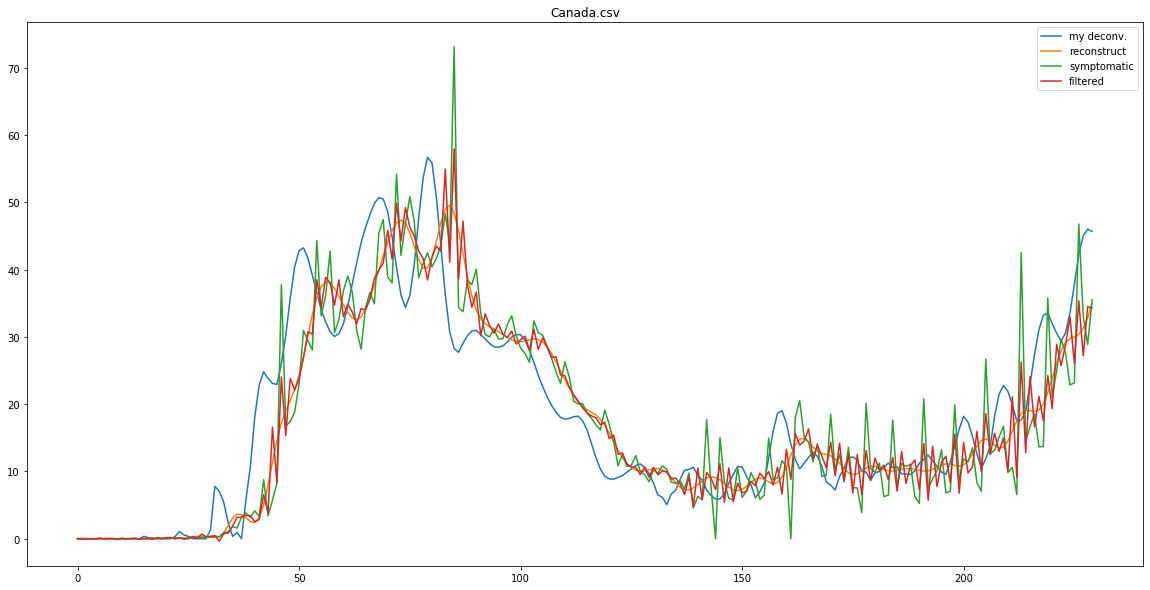

True


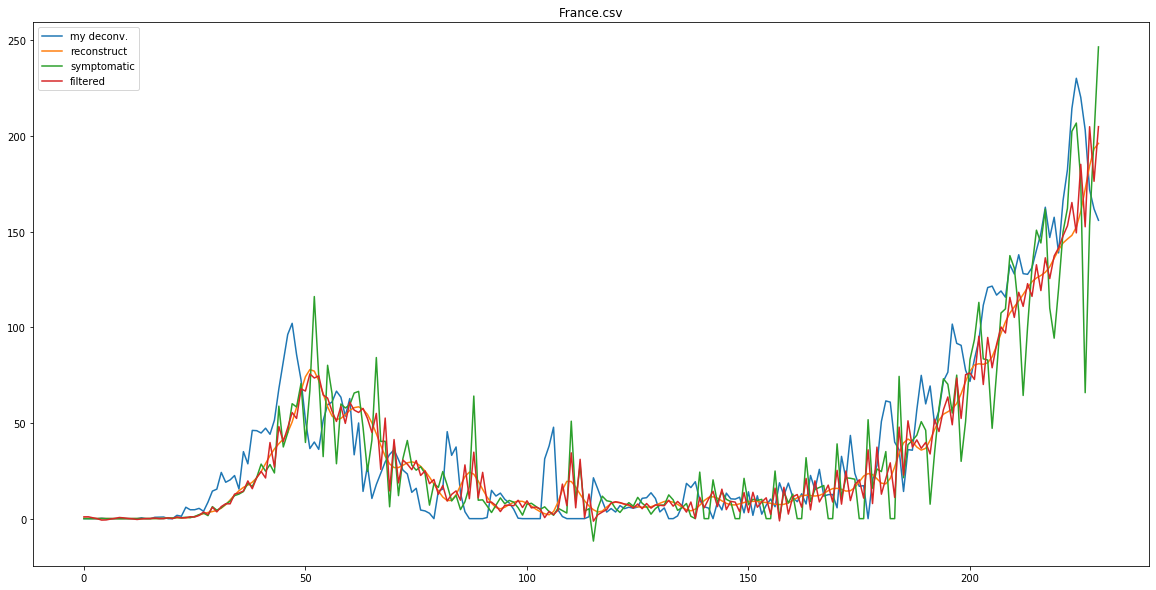

True


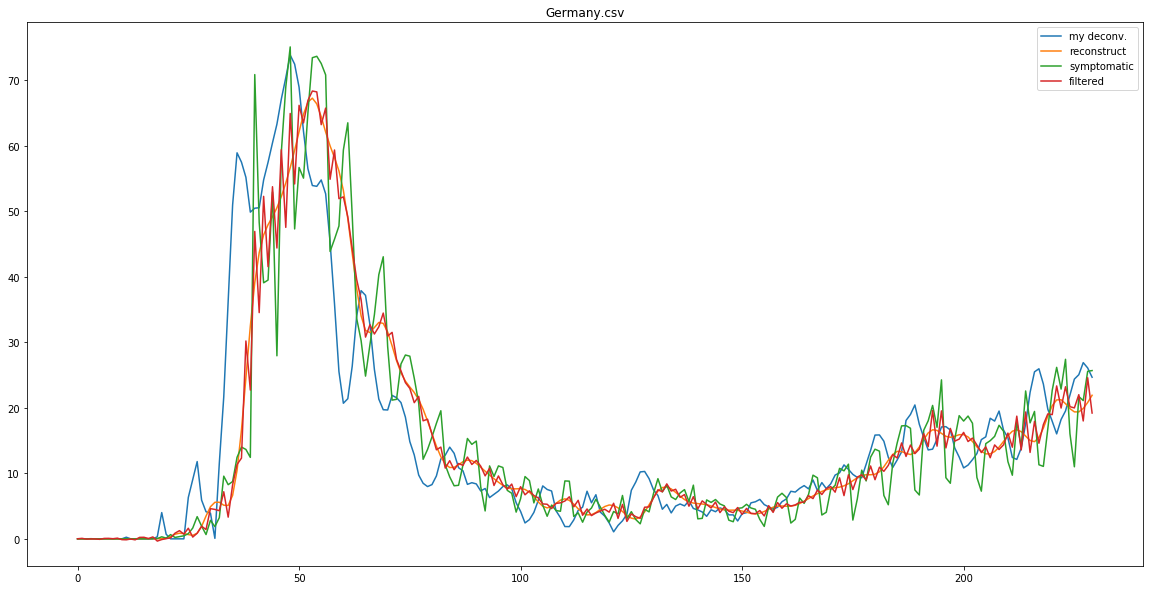

True


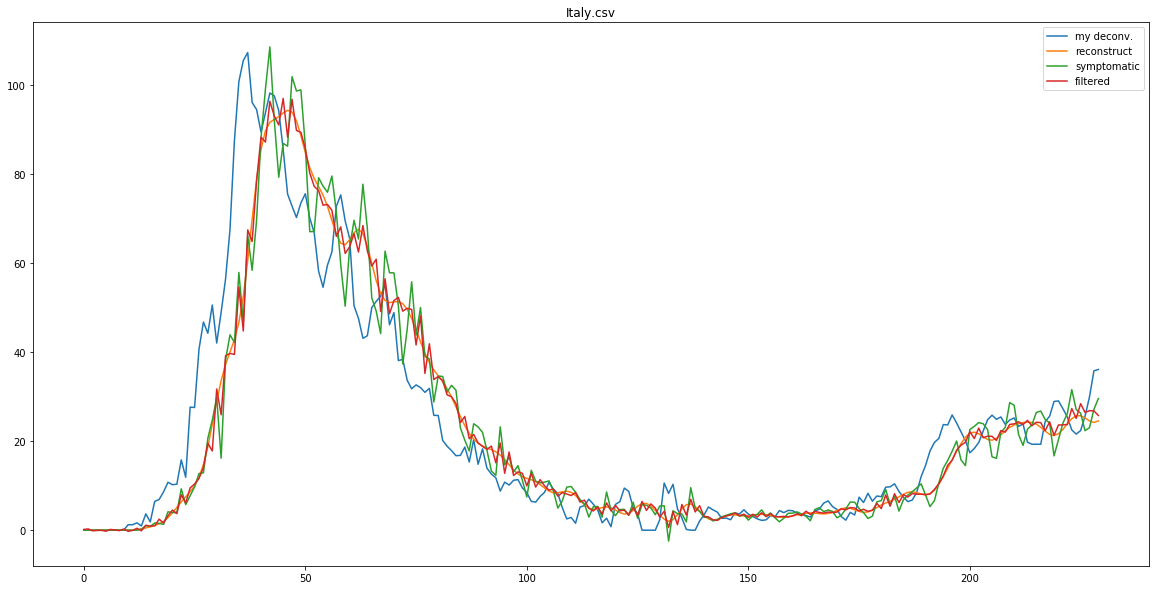

True


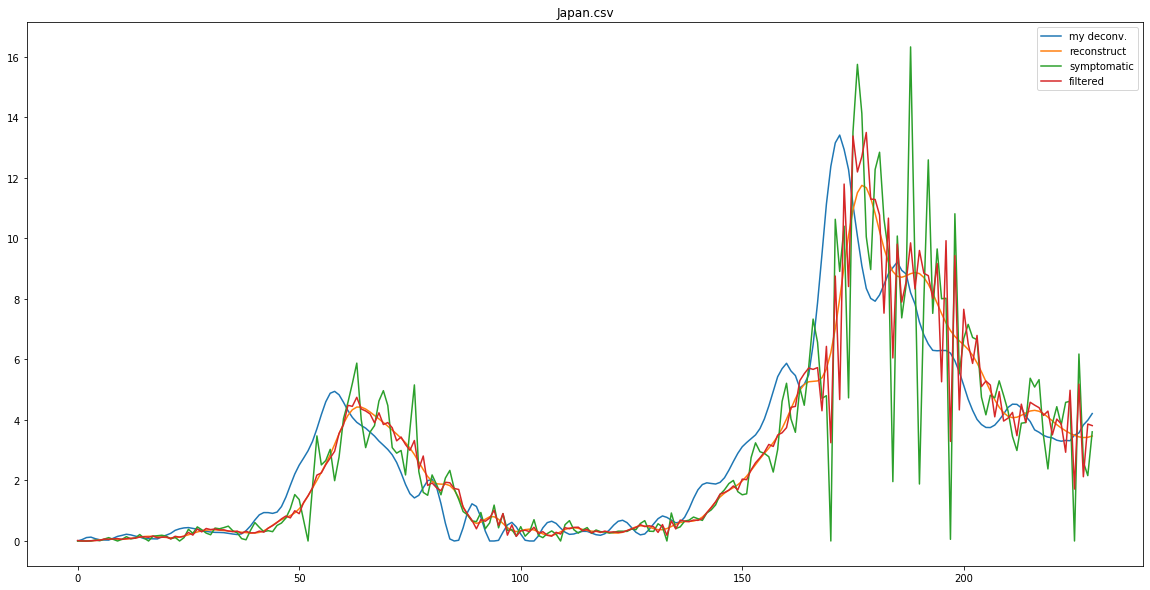

True


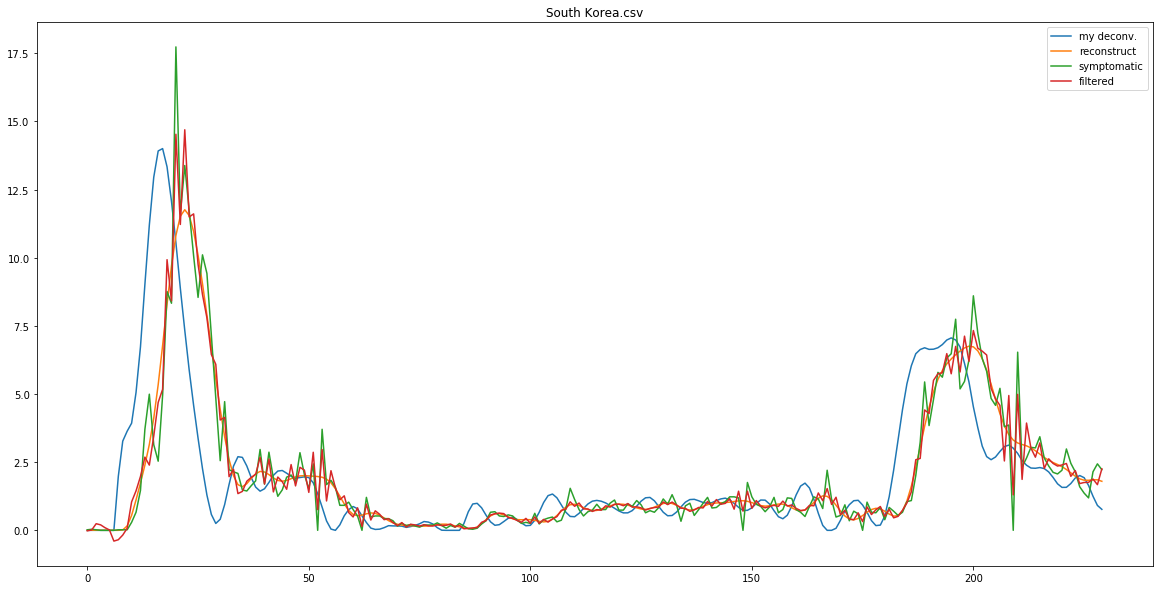

True


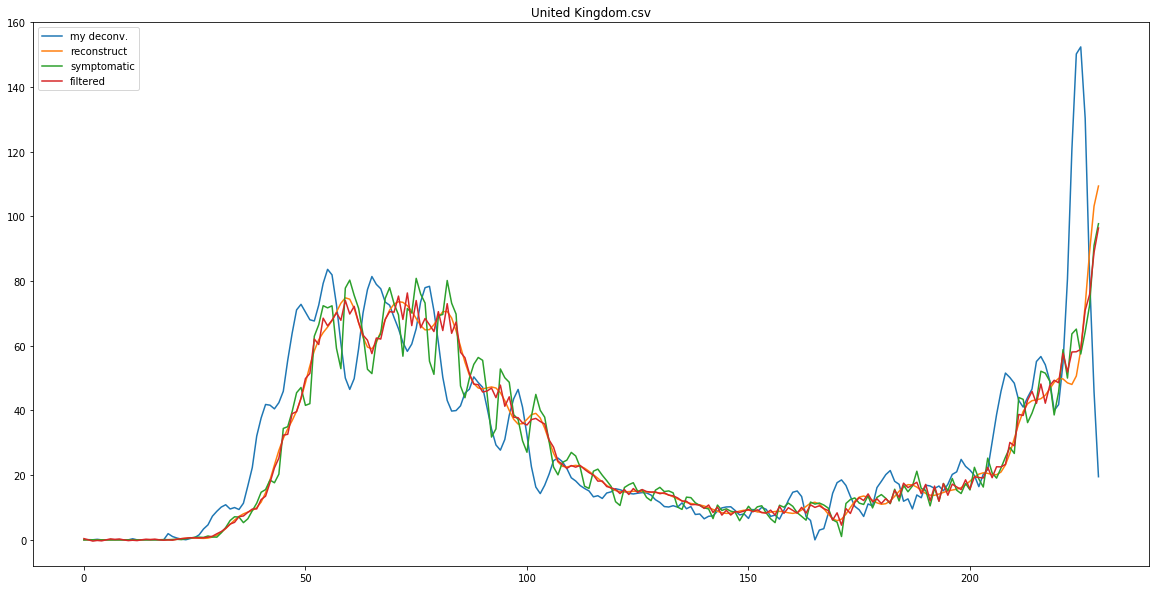

True


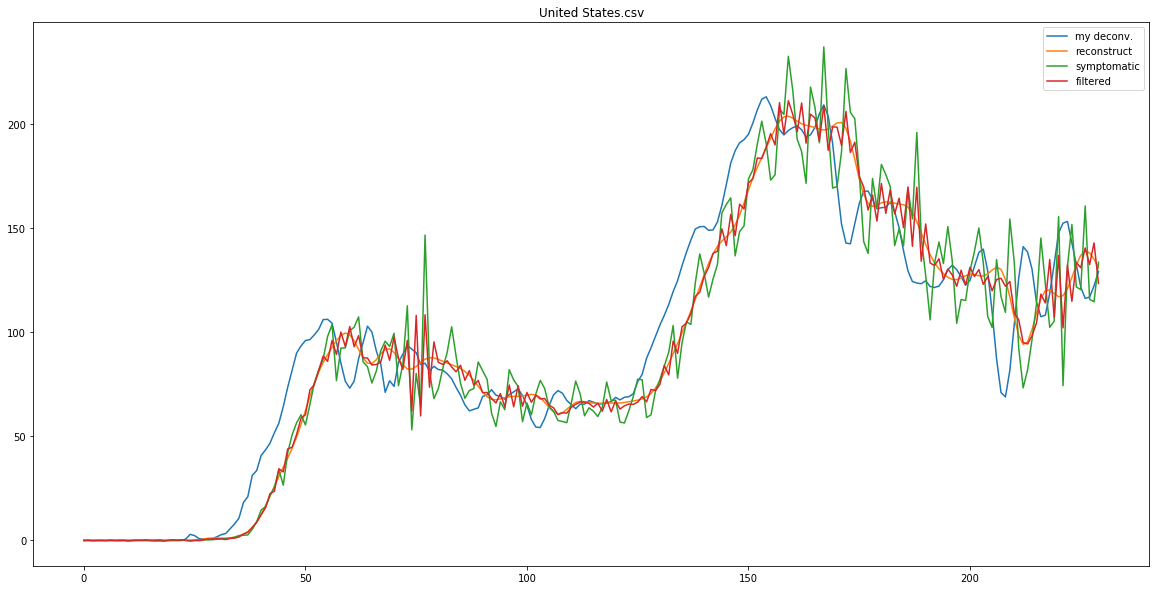

In [13]:
if not os.path.exists('deconv_mine'):
    os.mkdir('deconv_mine')

for country in os.listdir('data'):
    if country != 'owid-covid-data.xlsx':
        SEIR_outputs =  pd.read_csv('data/' + country)
        unfiltered_symptomatic_incidence =  SEIR_outputs['new_cases_per_million'].to_numpy() 
        symptomatic_incidence = show_filter(unfiltered_symptomatic_incidence, 4)


        def optimizer_function(real_incidence):
            L = len(true_kernel) - 1
            convolved = np.convolve(real_incidence, true_kernel, mode='valid')
            scaling = np.max(symptomatic_incidence[L:])

            scaled_convolved = convolved *1000000 #/np.max(symptomatic_incidence[L:]) *1000000
            scaled_incidence = symptomatic_incidence[L:] *1000000 #/np.max(symptomatic_incidence[L:]) *1000000

            penalty = 1E7 * np.mean(np.abs(np.diff(real_incidence)/scaling)**2)

            loglikelihoods = scaled_incidence*np.log(scaled_convolved) - scaled_convolved

            return -np.mean(loglikelihoods)+penalty
        #weiner_deconvolved = wiener_deconvolution(symptomatic_incidence, tr


        x0 = shift(symptomatic_incidence, -1*starting_shift)
        xs = minimize(optimizer_function, x0, bounds = [(0, np.inf) for _ in x0],options={'maxiter':200000}, method='Powell')

        print(xs.success)

        plt.figure(figsize=(20, 10))
        L = (len(true_kernel)-1)
        plt.plot(xs.x[L:-L], label='my deconv.')
        plt.plot(np.convolve(xs.x, true_kernel, mode='valid')[:-L], label='reconstruct')
        plt.plot(unfiltered_symptomatic_incidence[L:-L], label='symptomatic')
        plt.plot(symptomatic_incidence[L:-L], label='filtered')
        plt.title(country)
        plt.legend()
        plt.savefig('figures/'+ country +'deconv_mine.png')
        plt.show()

        test_df = pd.DataFrame()
        test_df['i'] =range(len(xs.x))#[L:-L]))
        test_df['deconv'] = xs.x#[L:-L]
        test_df['symptomatic'] = unfiltered_symptomatic_incidence#[L:-L]
        test_df.to_csv('deconv_mine/'+country, index=False)


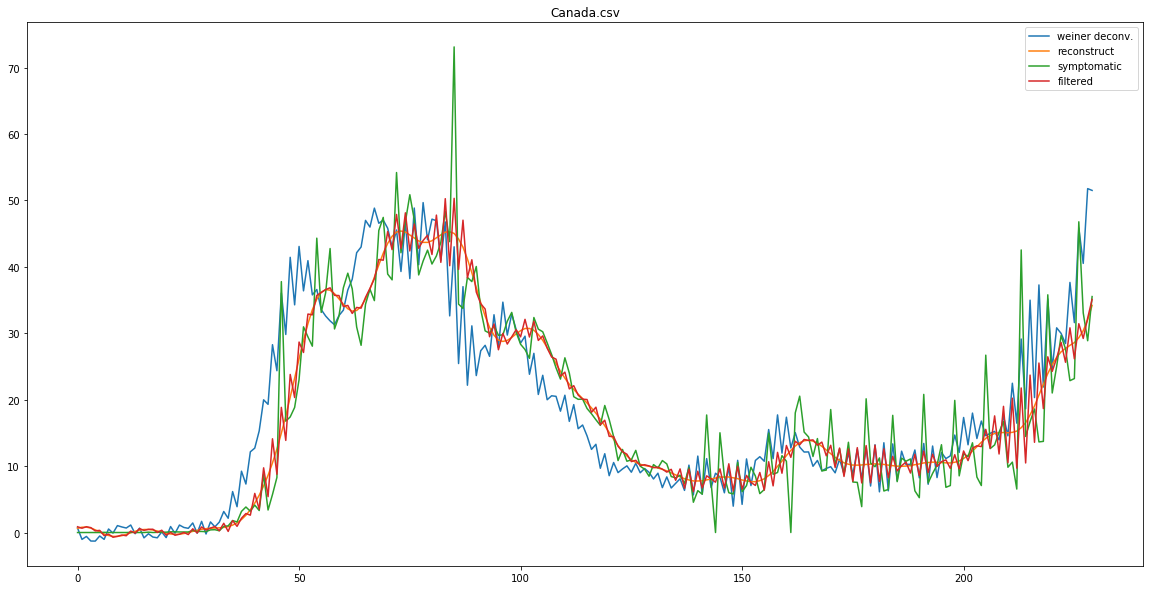

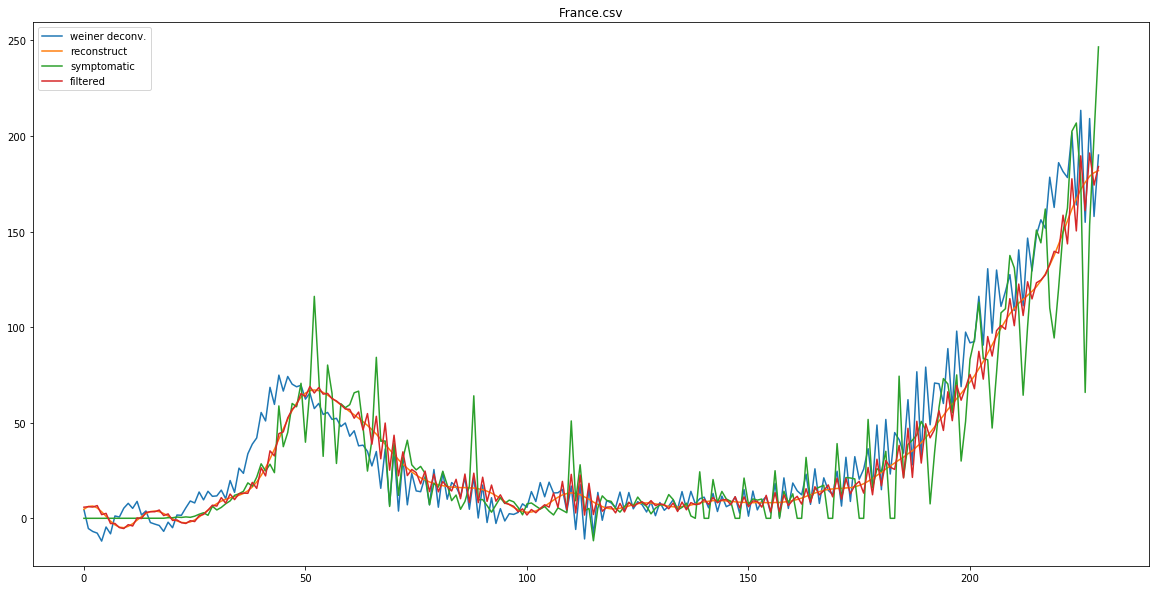

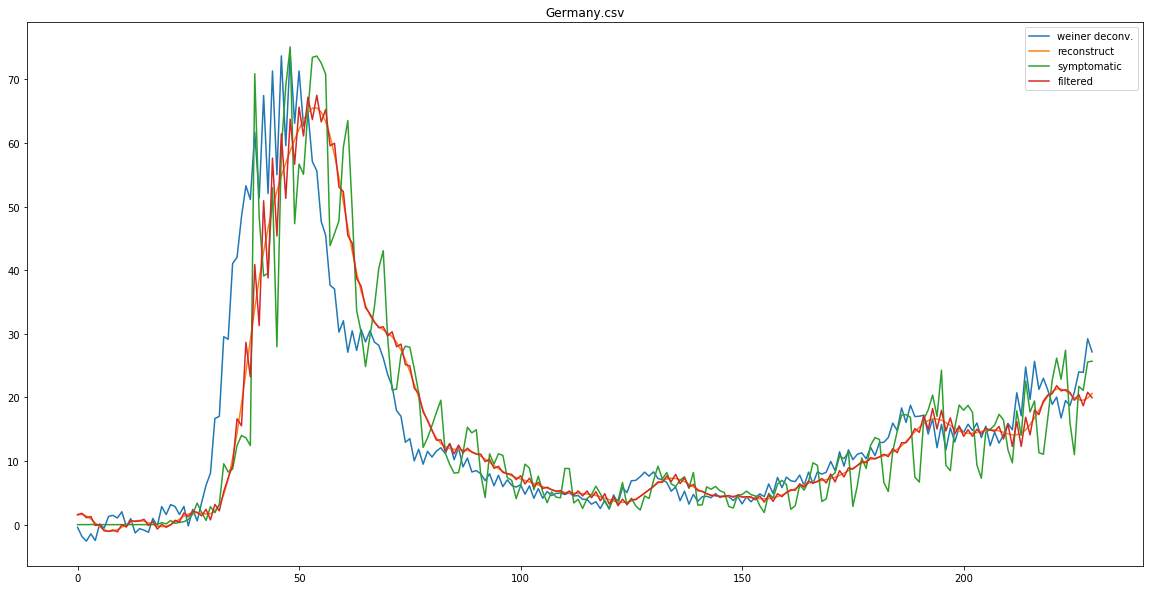

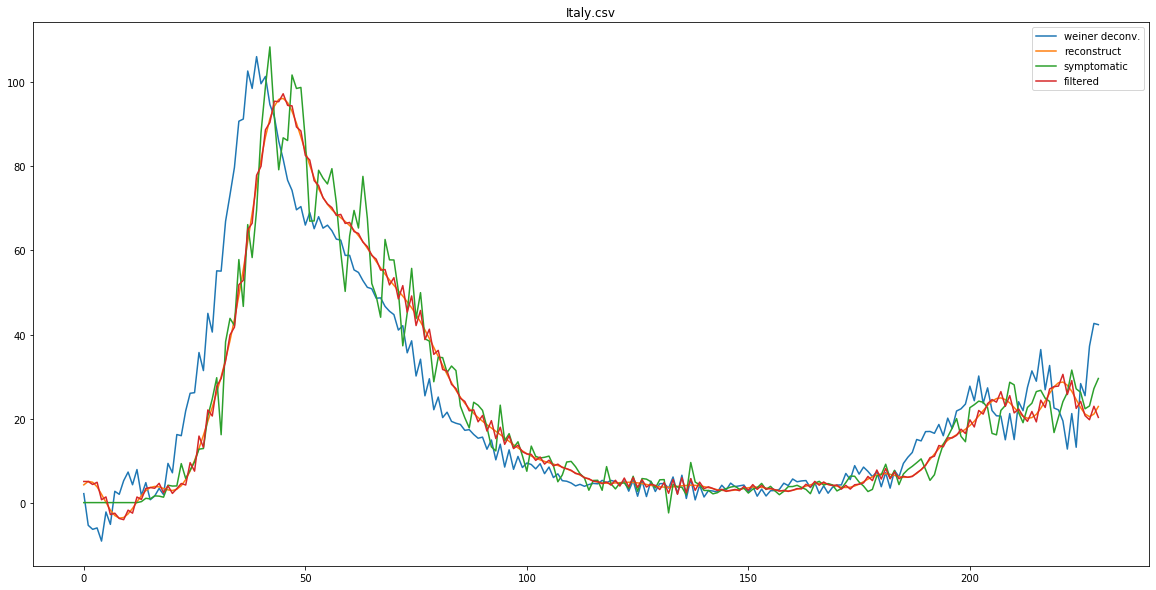

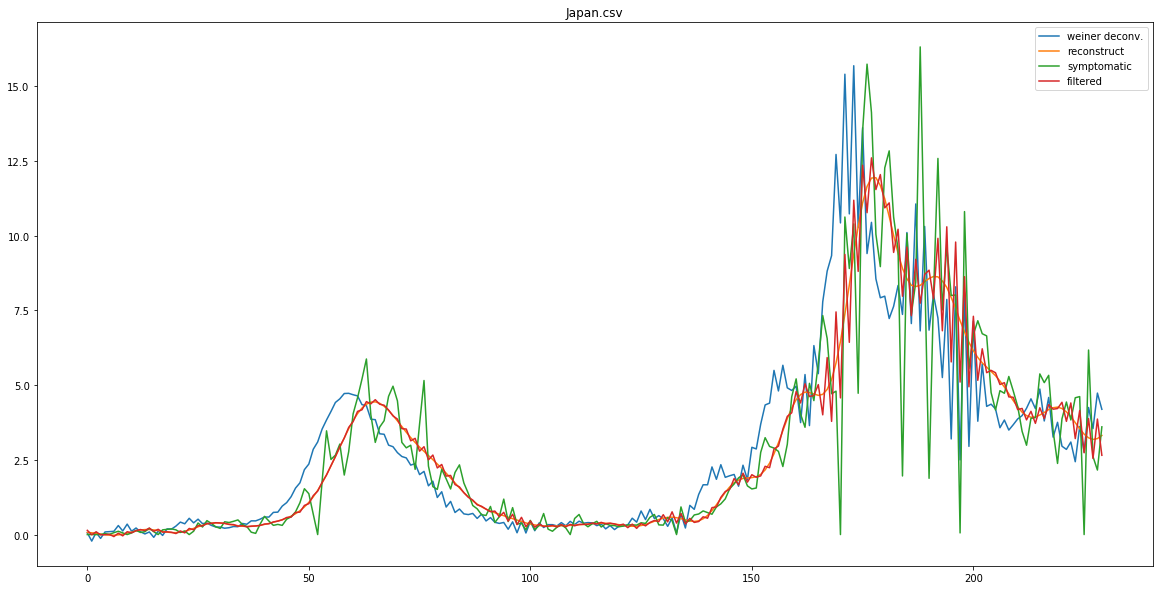

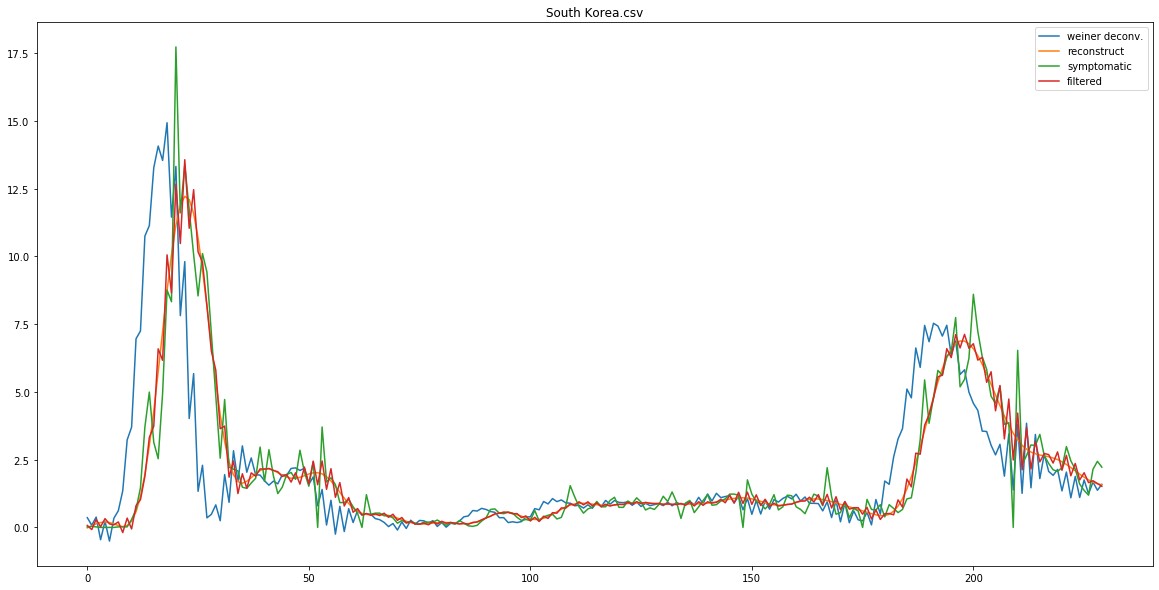

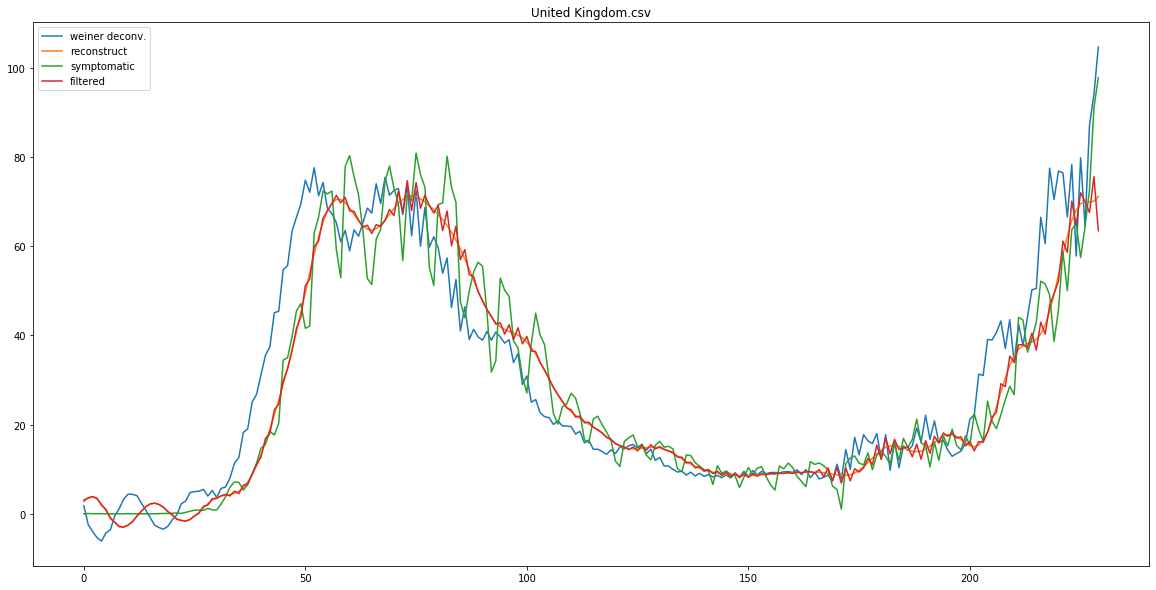

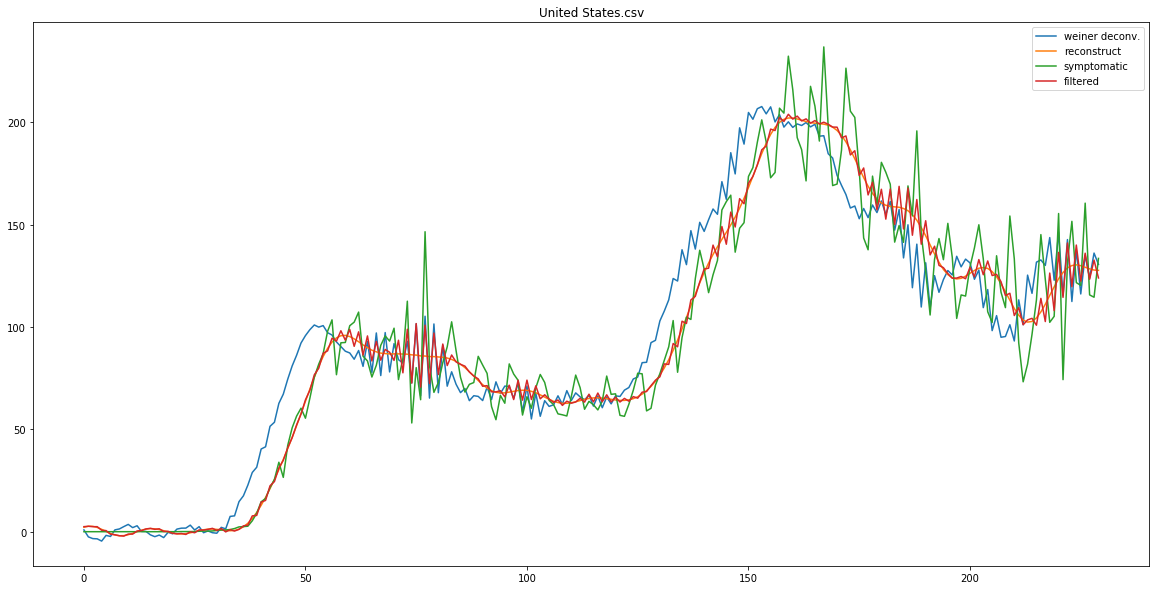

In [11]:

def wiener_deconvolution(signal, kernel, lambd):
	"lambd is the SNR"
	kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
	H = fft(kernel)
	deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + lambd**2)))
	return deconvolved

for country in os.listdir('data'):
    if country != 'owid-covid-data.xlsx':
        SEIR_outputs =  pd.read_csv('data/' + country)
        unfiltered_symptomatic_incidence =  SEIR_outputs['new_cases_per_million'].to_numpy() 
        symptomatic_incidence = show_filter(unfiltered_symptomatic_incidence, 7)

        
        wiener = wiener_deconvolution(symptomatic_incidence, true_kernel,0.05)

        plt.figure(figsize=(20, 10))
        L = (len(true_kernel)-1)
        plt.plot(wiener[L:-L], label='weiner deconv.')
        plt.plot(np.convolve(wiener, true_kernel, mode='valid')[:-L], label='reconstruct')
        plt.plot(unfiltered_symptomatic_incidence[L:-L], label='symptomatic')
        plt.plot(symptomatic_incidence[L:-L], label='filtered')
        plt.title(country)
        plt.legend()
        plt.savefig('figures/'+ country +'deconv_weiner.png')
        plt.show()

        test_df = pd.DataFrame()
        test_df['i'] =range(len(wiener))#[L:-L]))
        test_df['deconv'] = wiener#[L:-L]
        test_df['symptomatic'] = unfiltered_symptomatic_incidence#[L:-L]
        test_df.to_csv('deconv/'+country, index=False)


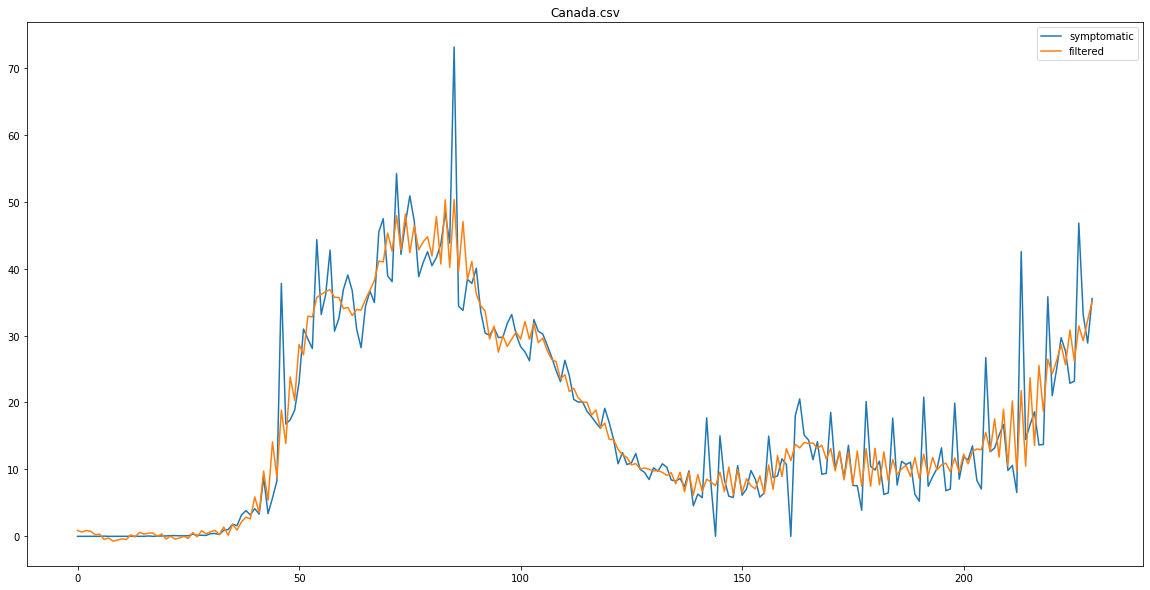

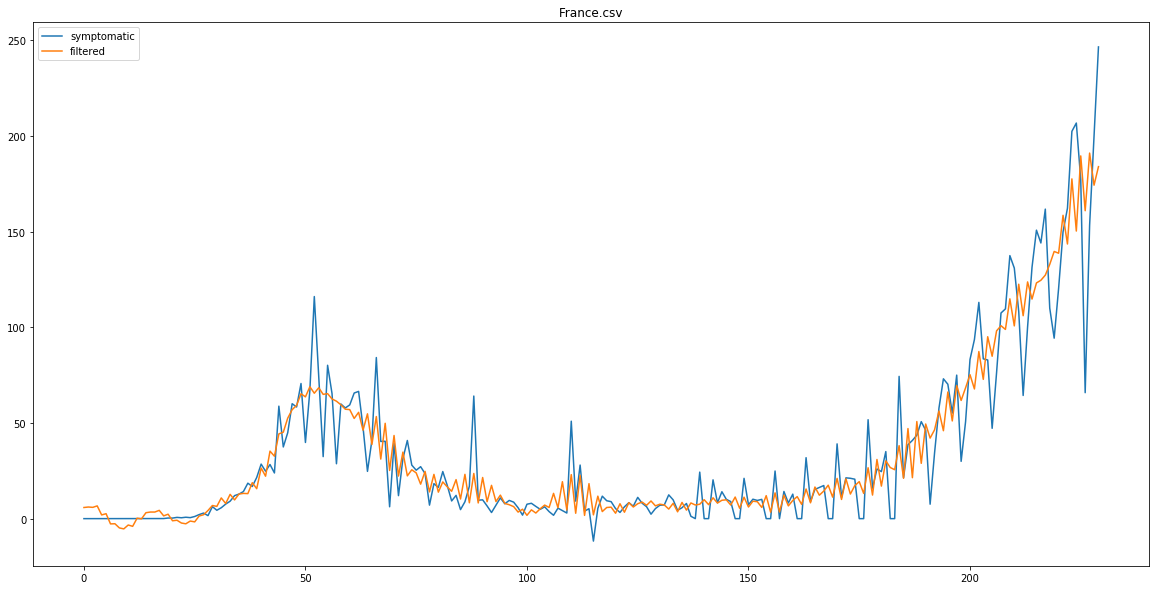

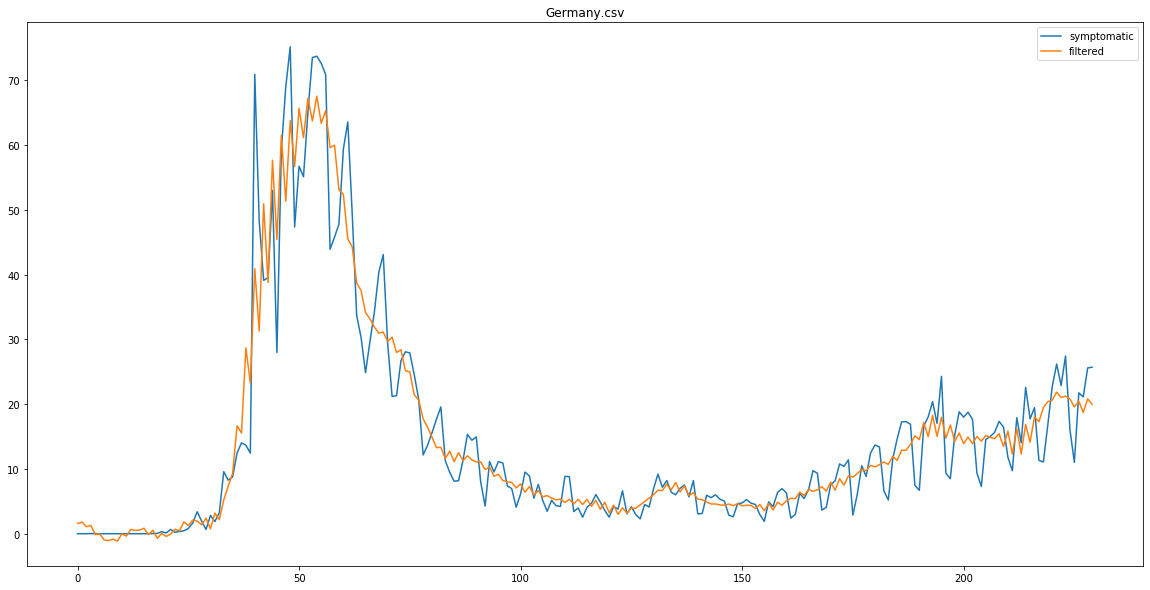

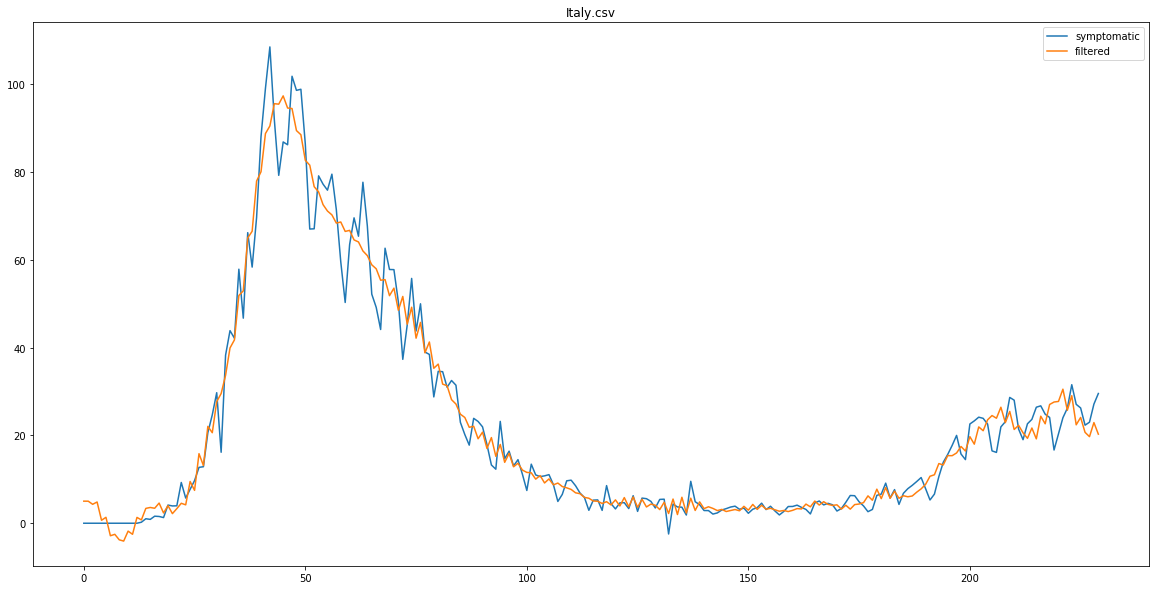

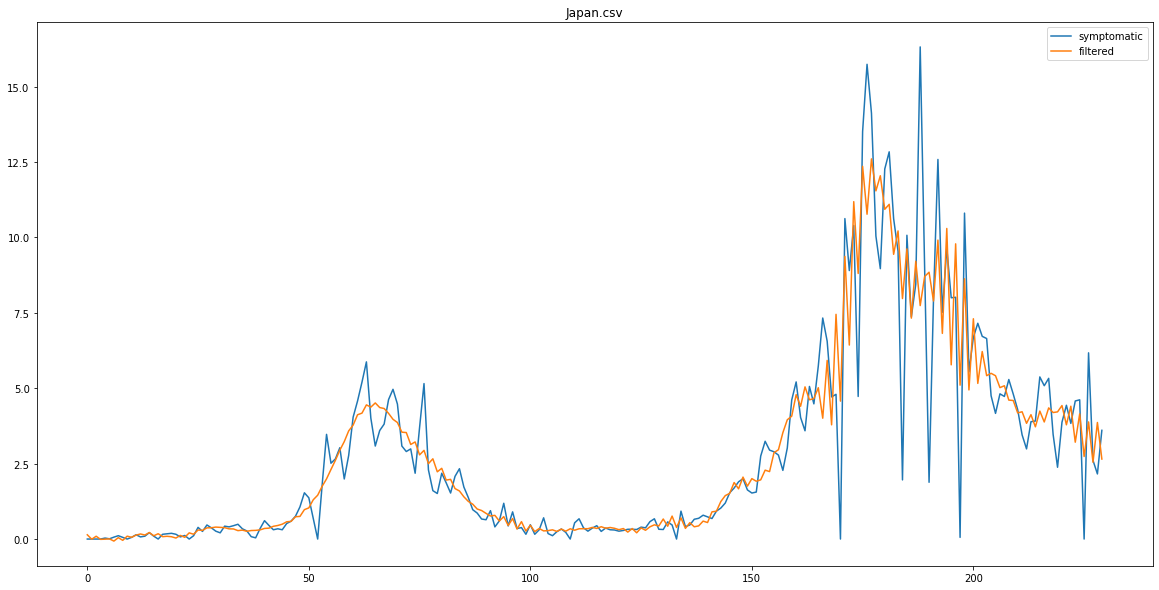

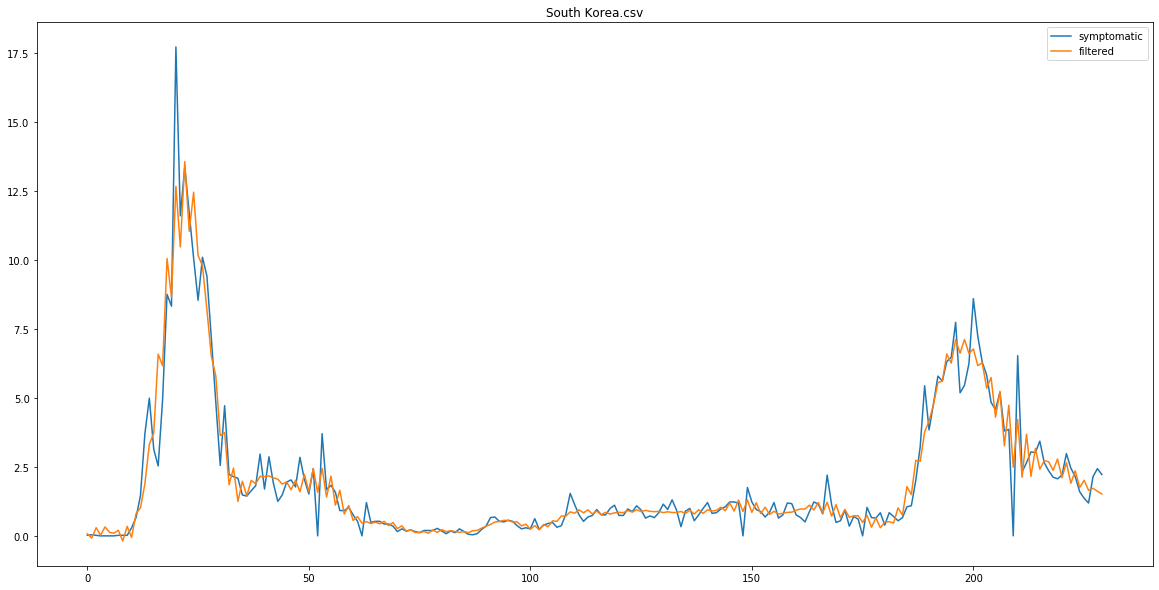

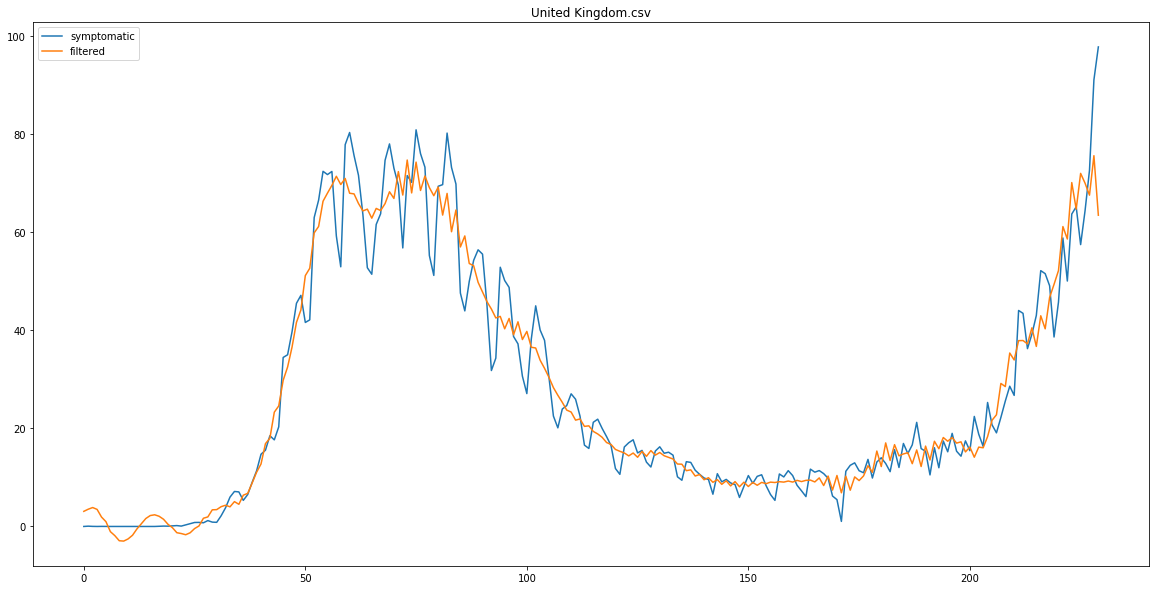

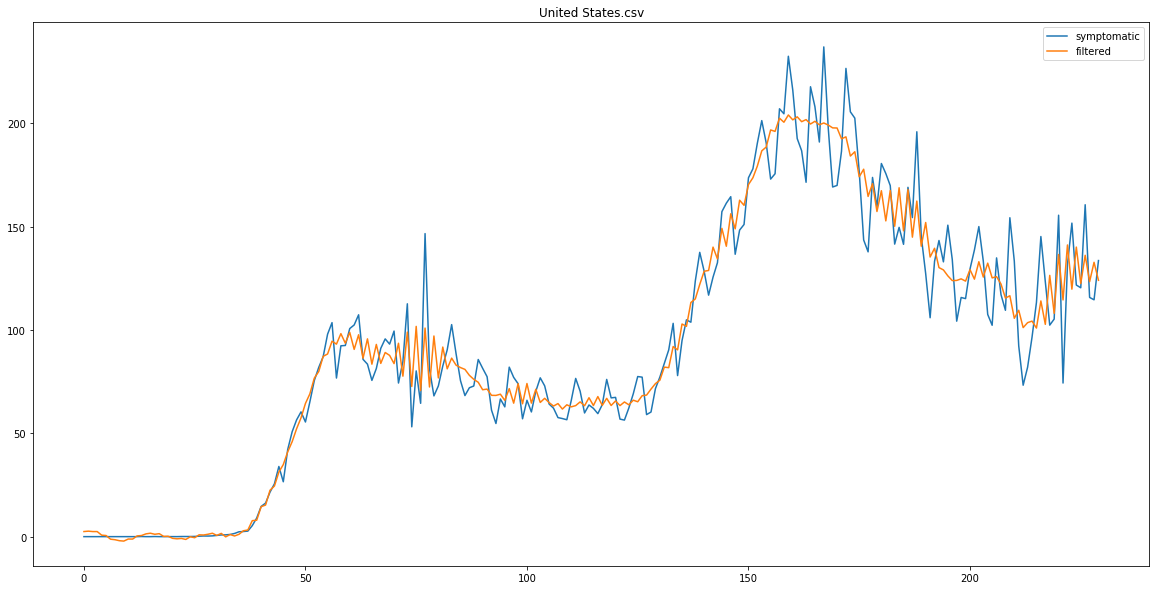

In [153]:

for country in os.listdir('data'):
    if country != 'owid-covid-data.xlsx':
        SEIR_outputs =  pd.read_csv('data/' + country)
        unfiltered_symptomatic_incidence =  SEIR_outputs['new_cases_per_million'].to_numpy() 
        symptomatic_incidence = show_filter(unfiltered_symptomatic_incidence, 7)

        plt.figure(figsize=(20, 10))
        L = (len(true_kernel)-1)

        plt.plot(unfiltered_symptomatic_incidence[L:-L], label='symptomatic')
        plt.plot(symptomatic_incidence[L:-L], label='filtered')
        plt.title(country)
        plt.legend()
        plt.savefig('figures/'+ country +'filter.png')
        plt.show()

        test_df = pd.DataFrame()
        test_df['i'] =range(len(xs.x[L:-L]))
        test_df['deconv'] = xs.x[L:-L]
        test_df['symptomatic'] = unfiltered_symptomatic_incidence[L:-L]
        test_df.to_csv('deconv_mine/'+country, index=False)
